# Data Loading

In [1]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew #for some statistics

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LassoCV

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

from subprocess import check_output
print(check_output(['ls', '../input/house-prices-advanced-regression-techniques']).decode('utf8')) #check the files available in the directory

data_description.txt
sample_submission.csv
test.csv
train.csv



In [2]:
#Now let's import and put the train and test datasets in  pandas dataframe

train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

In [3]:
#display the first five rows of the train dataset.
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#display the first five rows of the test dataset.
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
#check the numbers of samples and features
print(f'The train data size before dropping Id feature is : {train.shape}')
print(f'The test data size before dropping Id feature is : {test.shape} ')

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop('Id', axis = 1, inplace = True)
test.drop('Id', axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print(f'\nThe train data size after dropping Id feature is : {train.shape}')
print(f'The test data size after dropping Id feature is : {test.shape} ')

The train data size before dropping Id feature is : (1460, 81)
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80)
The test data size after dropping Id feature is : (1459, 79) 


# Data Processing 

## Target Variable 

Let's check the distribution  of SalePrice to ensure it is normal. If not, we would apply suitable transformation to make it normal.

mu = 180921.2 and sigma = 79415.29


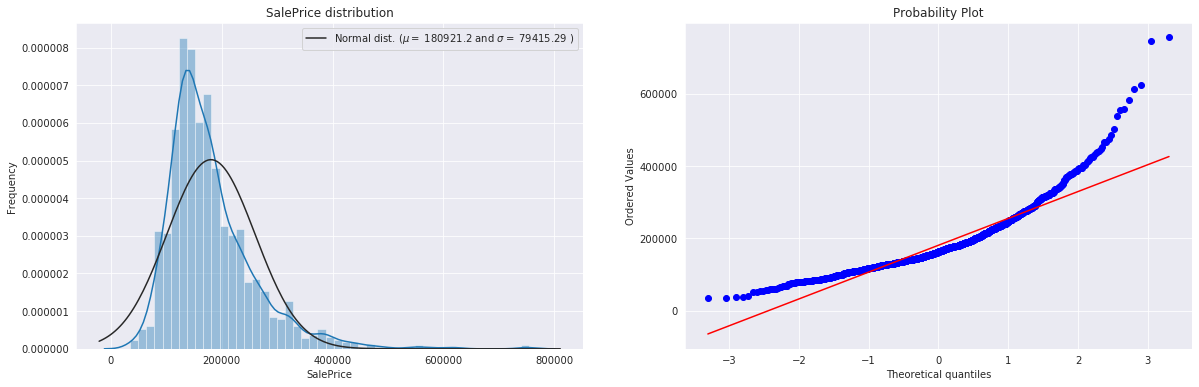

In [6]:
#Check the distribution
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,6))
sns.distplot(train['SalePrice'] , fit=norm, ax=ax1);

# Get the fitted parameters used by the function
mu, sigma = norm.fit(train['SalePrice'])
print(f'mu = {round(mu,2)} and sigma = {round(sigma,2)}')

#Now plot the distribution
ax1.legend([f'Normal dist. ($\mu=$ {round(mu,2)} and $\sigma=$ {round(sigma,2)} )'],
            loc='best')
ax1.set_ylabel('Frequency')
ax1.set_title('SalePrice distribution')

#Get also the QQ-plot
res = stats.probplot(train['SalePrice'],plot=ax2)

The target variable is right skewed. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed. A good choice would be the log transformation.

mu = 12.02 and sigma = 0.4


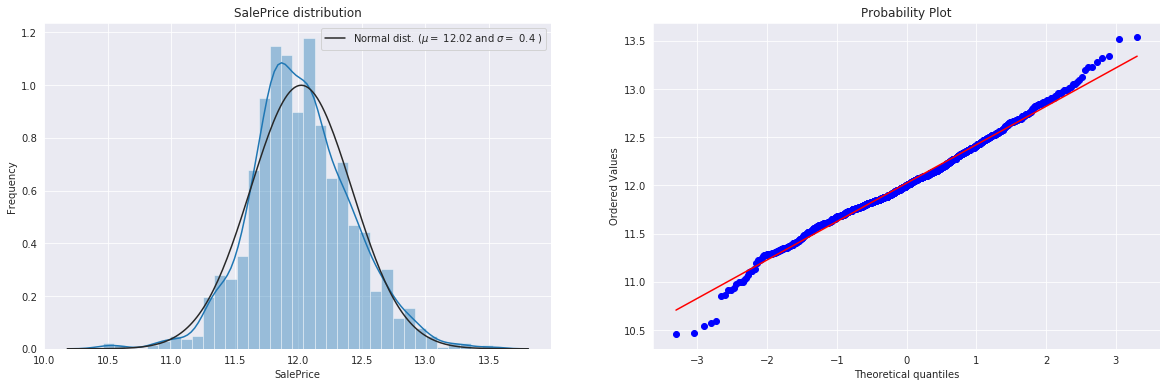

In [7]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train['SalePrice'] = np.log1p(train['SalePrice'])

#Check the new distribution
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,6))
sns.distplot(train['SalePrice'] , fit=norm, ax=ax1);

#Get the fitted parameters used by the function
mu, sigma = norm.fit(train['SalePrice'])
print(f'mu = {round(mu,2)} and sigma = {round(sigma,2)}')

#Now plot the distribution
ax1.legend([f'Normal dist. ($\mu=$ {round(mu,2)} and $\sigma=$ {round(sigma,2)} )'],
            loc='best')
ax1.set_ylabel('Frequency')
ax1.set_title('SalePrice distribution')

#Get also the QQ-plot
res = stats.probplot(train['SalePrice'],plot=ax2)

The skew seems now corrected and the data appears more normally distributed.

Let's merge the train and test data for handling missing values and other preprocessing. Also, we retain the number of train and test indices.

In [8]:
ntrain = train.shape[0]
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print(f'all_data size is : {all_data.shape}')

all_data size is : (2919, 79)


## Missing Data

### Finding missing values

Text(0.5, 1.0, 'Percent missing data by feature')

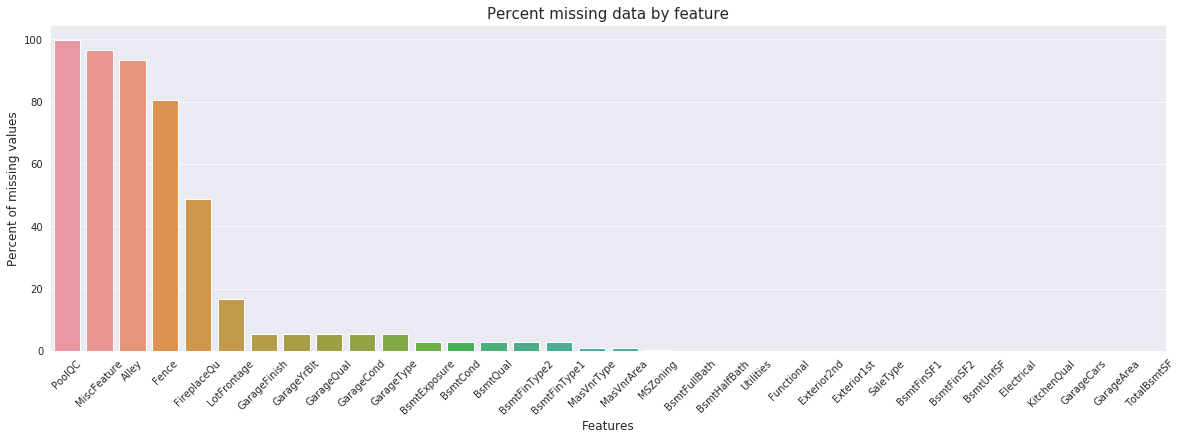

In [9]:
#Find percentage of missing data
missing_data = (all_data.isnull().sum() / len(all_data)) * 100
missing_data = missing_data[missing_data != 0].sort_values(ascending=False)

#Plot the missing data
plt.figure(figsize=(20,6))
sns.barplot(x=missing_data.index, y=missing_data)
plt.xticks(rotation=45)
plt.xlabel('Features',fontsize=12)
plt.ylabel('Percent of missing values', fontsize=12)
plt.title('Percent missing data by feature', fontsize=15)

### Imputing missing values

Features with missing values more than 20% missing values and other features related to them could be  dropped as the data available for them is too small to be used with confidence. However, as lasso regression will be used, they will automatically be discarded if they are not significant. Hence, all features are kept and imputed appropriately based on the data description.

In [10]:
#Handle missing values

#Fill 'None' in categorical features to indicate absence of feature
none_features = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageType',
                 'BsmtExposure', 'BsmtCond', 'BsmtQual','BsmtFinType2', 'BsmtFinType1', 'MasVnrType']
all_data.fillna({col:'None' for col in none_features}, inplace =True)

#Fill 0 in numerical features to indicate absence of feature
zero_features = ['GarageYrBlt', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 
                 'BsmtUnfSF', 'GarageCars', 'GarageArea', 'TotalBsmtSF']
all_data.fillna({col:0 for col in zero_features}, inplace =True)

#Fill mode of some features(consider only the training set) where <1% data is missing and nothing else can be inferred from description
mode_features = ['MSZoning', 'Utilities', 'Functional', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Electrical', 'KitchenQual']
all_data.fillna({col:all_data[col][:ntrain].mode()[0] for col in mode_features}, inplace = True)

#Fill LotFrontage with median value(consider only the training set) from the neighbourhood
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x[:ntrain].median()))

Is there any remaining missing value ?

In [11]:
#Check remaining missing values if any 
missing_data = (all_data.isnull().sum() / len(all_data)) * 100
missing_data = missing_data[missing_data != 0].sort_values(ascending=False)
missing_data.rename('Percentage missing data')

Series([], Name: Percentage missing data, dtype: float64)

No missing value remains.

## Numerical Features

### Transforming some numerical features to categorical

In [12]:
# Some numerical features are actually really categories
num_to_cat_features = ['MSSubClass', 'OverallQual', 'OverallCond', 'MoSold', 'YrSold']
all_data[num_to_cat_features] = all_data[num_to_cat_features].astype(str)

### Removing skew

First, we see how all numerical features are skewed.

Text(0.5, 1.0, 'Skewness by feature')

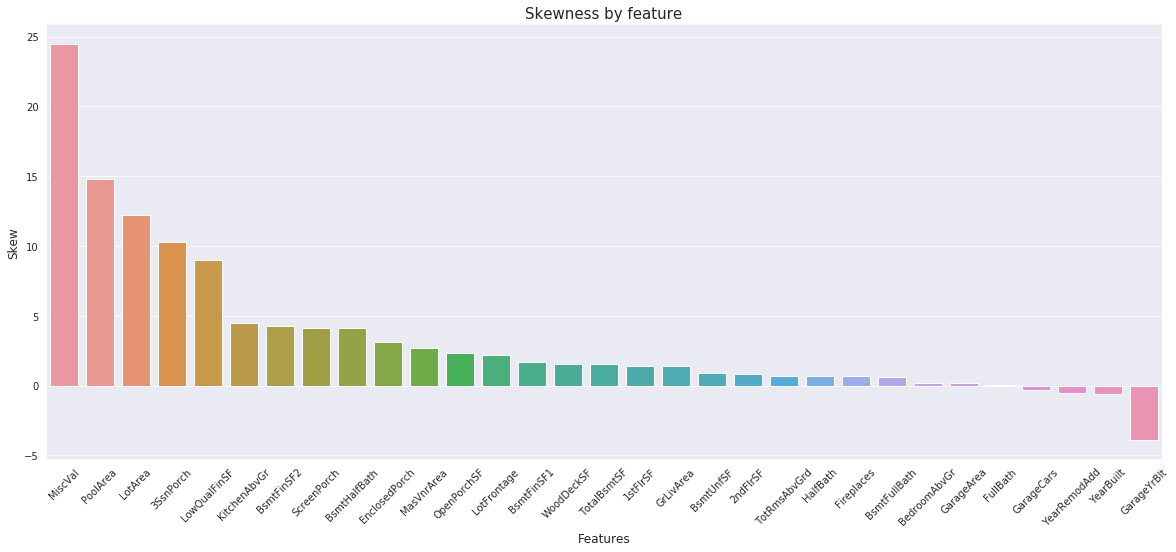

In [13]:
#Find the skew of each feature(consider only training set for finding skew)
numerical_features = all_data.select_dtypes(exclude=['object']).columns
skewed = all_data[numerical_features].apply(lambda x : skew(x[:ntrain])).sort_values(ascending=False)

#Plot the skew of each feature
plt.figure(figsize=(20,8))
sns.barplot(x=skewed.index, y=skewed)
plt.xticks(rotation=45)
plt.xlabel('Features',fontsize=12)
plt.ylabel('Skew', fontsize=12)
plt.title('Skewness by feature', fontsize=15)

We log transfrom the features whose absolute value of skew is >0.5. The value 0.5 is chosen as a rule of thumb.

In [14]:
skewed_features = skewed[abs(skewed)>0.5].index
all_data[skewed_features] = np.log1p(all_data[skewed_features])

Check the skew after transformation.

Text(0.5, 1.0, 'Skewness by feature')

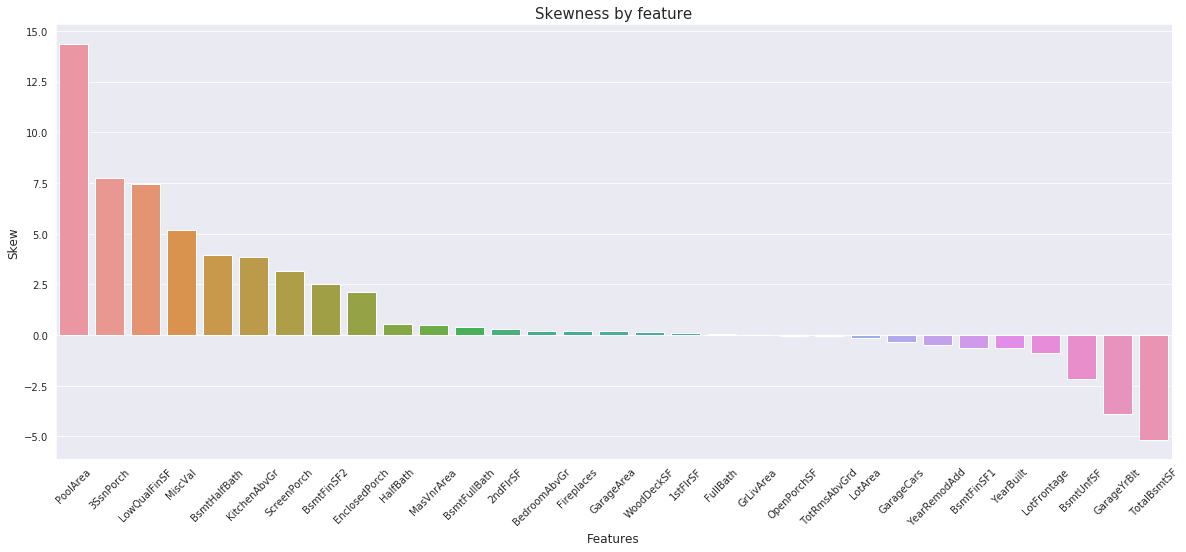

In [15]:
skewed = all_data[numerical_features].apply(lambda x : skew(x[:ntrain])).sort_values(ascending=False)

#Plot the skew of each feature
plt.figure(figsize=(20,8))
sns.barplot(x=skewed.index, y=skewed)
plt.xticks(rotation=45)
plt.xlabel('Features',fontsize=12)
plt.ylabel('Skew', fontsize=12)
plt.title('Skewness by feature', fontsize=15)

Most features have been transformed such that their skew has been reduced significantly. The features in which high skew remains is due to most of the data having similar values and having some outliers.

### Scaling

Scaling is important so that the regularization penalizes every thing uniformly.

In [16]:
#Scaling the features so that all of them lie in [0,1]
scaler = MinMaxScaler()
scaler.fit(all_data[numerical_features][:ntrain])
all_data[numerical_features] = scaler.transform(all_data[numerical_features])

#Check that data size is preserved.
print(f'all_data size is : {all_data.shape}')

all_data size is : (2919, 79)


## Categorical Features

I am using one hot encoding as it does not make the dataset very big and will provide maximum accuracy.

In [17]:
all_data = pd.get_dummies(all_data)

#Check that number of rows is preserved
print(f'all_data size is : {all_data.shape}')

all_data size is : (2919, 349)


# Modelling

In [18]:
#Separate the train and test data
X_train = all_data[:ntrain]
y_train = train['SalePrice']
X_test = all_data[ntrain:]

#Check whether the datasets have correct size
print(f'train size is : {X_train.shape}')
print(f'target size is: {y_train.shape}')
print(f'test size is : {X_test.shape}')

train size is : (1460, 349)
target size is: (1460,)
test size is : (1459, 349)


Now, we will fit a lasso model with builtin cross-validation to the training data. The advantage of lasso is that it increases model intrepretability by dropping unimportant features. But, first we have to find optimum penalty parameter alpha.

Text(0.5, 1.0, 'Variation of root mean squared error with penalty factor')

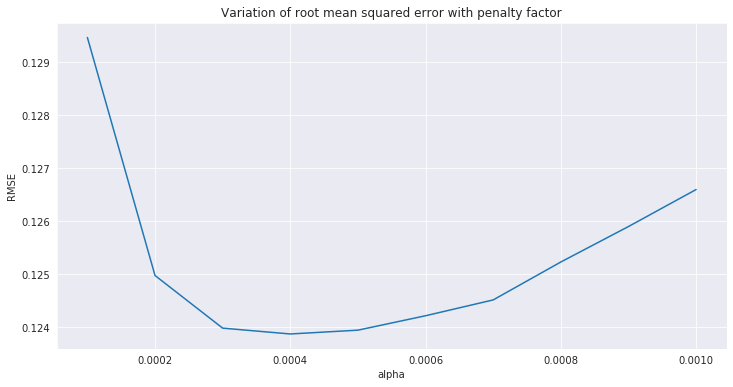

In [19]:
#Use a plot of rmse vs alpha to find rough estimate of optimum alpha
alphas = [0.0001*x for x in  range(1,11)]
cv_score = [np.sqrt(-cross_val_score(LassoCV(alphas=[alpha], max_iter = 50000, cv=10), X_train, y_train, 
                                     scoring = 'neg_mean_squared_error', cv=10, n_jobs=4).mean()) for alpha in alphas]
plt.figure(figsize = (12,6))
sns.lineplot(x=alphas, y = cv_score)
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.title('Variation of root mean squared error with penalty factor')

The optimum value of alpha is between 0.00035 and 0.00045

Optimum value of alpha is 0.00038
Root mean squared error on training set is 0.12387
Lasso picked 151 features and eliminated the other 198 features


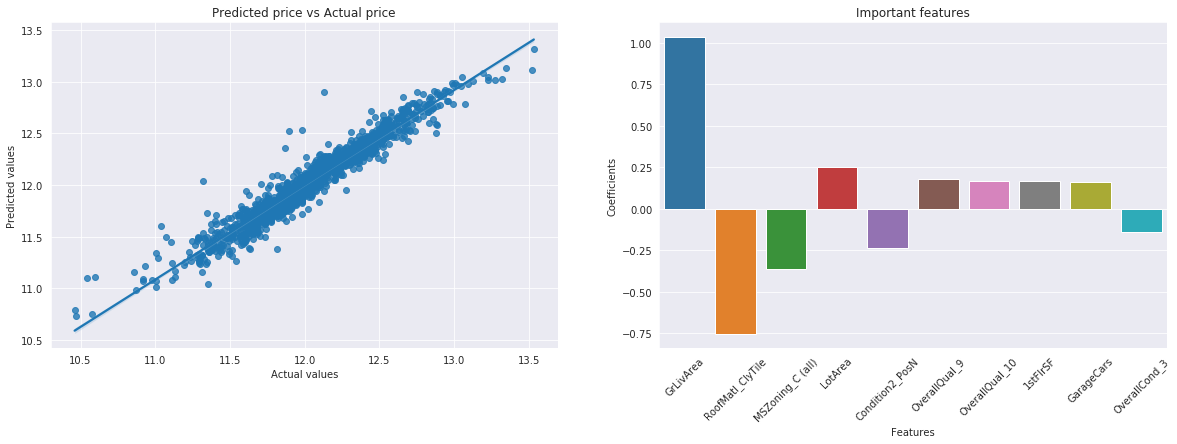

In [20]:
# Fit the lasso model using the optimum alpha
lasso = LassoCV(alphas = [0.00035 + 0.00001*x for x in range(0,11)], max_iter = 50000, cv=10)
lasso.fit(X_train,y_train)
alpha = lasso.alpha_
print(f'Optimum value of alpha is {round(alpha,5)}')

#Find RMSE 
rmse = np.sqrt(-cross_val_score(LassoCV(alphas = [alpha]), X_train, y_train, scoring = 'neg_mean_squared_error', cv=10, n_jobs=4).mean())
print(f'Root mean squared error on training set is {round(rmse,5)}')

#Plot predictions
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,6))
sns.regplot(x = y_train, y = lasso.predict(X_train), ax=ax1)
ax1.set_title('Predicted price vs Actual price')
ax1.set_xlabel('Actual values')
ax1.set_ylabel('Predicted values')

#Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print(f'Lasso picked {sum(coefs != 0)} features and eliminated the other {sum(coefs == 0)} features')
imp_coefs = coefs.reindex(coefs.abs().sort_values(ascending = False).index)[:10]
sns.barplot(x=imp_coefs.index,y=imp_coefs.values, ax=ax2)
ax2.set_title('Important features')
ax2.set_xlabel('Features')
ax2.set_ylabel('Coefficients')
ax2.tick_params(axis='x', labelrotation = 45)

Finally, we are ready to fit our model and submit the predictions.

In [21]:
y_test = lasso.predict(X_test)
submission = pd.DataFrame({'Id' : test_ID, 'SalePrice' : np.exp(y_test)-1})
submission.to_csv('submission.csv', index=False)